## Flower Image Prediction Competition
Let's share our models to a centralized leaderboard, so that we can collaborate and learn from the model experimentation process...

**Instructions:**
1.   Get data in and set up X_train / X_test / y_train
2.   Preprocess data, Write and Save Preprocessor function
3. Fit model on preprocessed data and save preprocessor function and model 
4. Generate predictions from X_test data and submit model to competition
5. Repeat submission process to improve place on leaderboard



## 1. Get data in and set up X_train, X_test, y_train objects

In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [2]:
# Get competition data
from aimodelshare import download_data

download_data('public.ecr.aws/x8e4b0t0/flower_competition_data-repository:latest') 


Data downloaded successfully.


##2.   Preprocess data  / Write and Save Preprocessor function


In [3]:
# Here is a pre-designed preprocessor, but you could also build your own to prepare the data differently

def preprocessor(image_filepath, shape=(192, 192)):
        """
        This function preprocesses reads in images, resizes them to a fixed shape and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.
        
        params:
            image_filepath
                full filepath of a particular image
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(image_filepath) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] for keras model.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

In [4]:
# Extract filepaths to use to import and preprocess image files...
base_path = 'flower_competition_data/train_images'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object...
import os

fnames = []

for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

#print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:4]) # Examples of file names...

In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform...
trainingdata_filepaths=fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]

# Read in all images from filenames...
preprocessed_image_data = [preprocessor(x) for x in trainingdata_filepaths]

# tf.keras models require object to be an array rather than a list. (vstack converts above list to array object.)
import numpy as np
X = np.vstack(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model.


X.shape

(2936, 192, 192, 3)

In [6]:
# Create y training label data made up of correctly ordered labels from file folders...
from itertools import repeat

daisy = list(repeat("daisy", 507)) #i.e.: 507 filenames in daisy training data folder
dandelion = list(repeat("dandelion", 718))
roses = list(repeat("roses", 513))
sunflowers = list(repeat("sunflowers", 559))
tulips = list(repeat("tulips", 639))

# Combine into single list of y labels...
y_labels = daisy + dandelion + roses + sunflowers + tulips

# Check length, same as X above...
len(y_labels) 

# Need to one-hot encode for Keras. Let's use Pandas...
import pandas as pd
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2931,0,0,0,0,1
2932,0,0,0,0,1
2933,0,0,0,0,1
2934,0,0,0,0,1


In [7]:
from sklearn.model_selection import train_test_split

# train_test_split resized images...
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20)

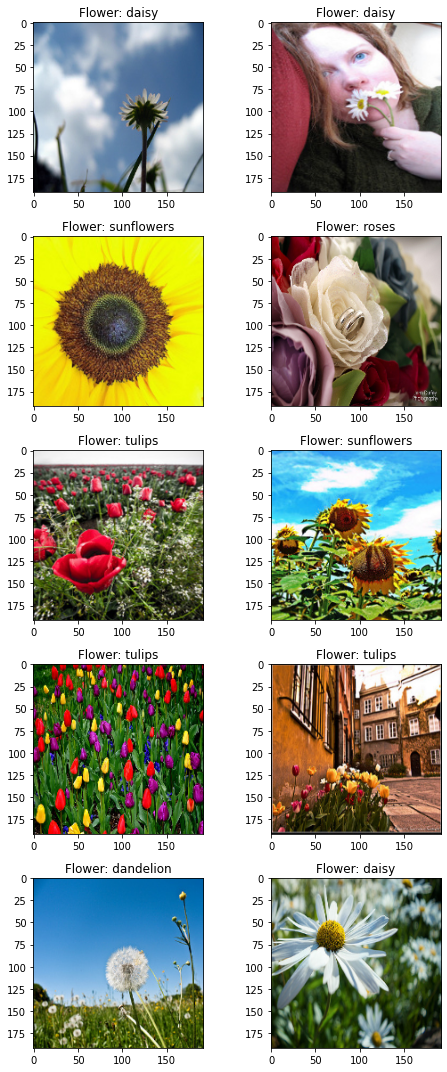

In [8]:
# Visualize images...
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])
        
plt.tight_layout()



##3. Fit model on preprocessed data and save preprocessor function and model 


In [9]:
# Let's build a convnet model...
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(16, activation='relu')) # One fully-connected layer of 16 neurons.
        model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        hist = model.fit(X_train, y_train,
                          epochs=2, verbose=1, validation_split=.2)



Epoch 1/2
59/59 [==============================] - 35s 577ms/step - loss: 1.7844 - accuracy: 0.2540 - val_loss: 1.5388 - val_accuracy: 0.2617
Epoch 2/2
59/59 [==============================] - 34s 573ms/step - loss: 1.4933 - accuracy: 0.3344 - val_loss: 1.4710 - val_accuracy: 0.3745


#### Save preprocessor function to local "preprocessor.zip" file

In [10]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


#### Save model to local ".onnx" file

In [11]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True, epochs=2)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## 4. Generate predictions from X_test data and submit model to competition


In [12]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials
    
apiurl='https://grzgnt36z2.execute-api.us-east-1.amazonaws.com/prod/m'
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [13]:
#Instantiate Competition

mycompetition= ai.Competition(apiurl)

In [14]:
# Preprocess X_test image data to generate predictions from models 
import numpy as np

file_names = [('flower_competition_data/test_images/' + str(i) + '.jpg') for i in range(1, 735)]

preprocessed_image_data = [preprocessor(x) for x in file_names]

#Create single X_test array from preprocessed images
X_test = np.vstack(preprocessed_image_data) 

In [15]:
#Submit Model 1: 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): conv2d, flower competition
Provide any useful notes about your model (optional): conv2d, one layer

Your model has been submitted as model version 1

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:866


In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)

## 5. Repeat submission process to improve place on leaderboard


In [ ]:
# Train and submit model 2 using same preprocessor (note that you could save a new preprocessor, but we will use the same one for this example).
# Let's build a convnet model...
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(16, activation='relu')) # One fully-connected layer of 16 neurons.
        model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


        # Fitting the NN to the Training set...
        hist = model.fit(X_train, y_train,
                          epochs=3, verbose=1, validation_split=.2)


Epoch 1/3
59/59 [==============================] - 54s 912ms/step - loss: 1.5772 - accuracy: 0.2812 - val_loss: 1.5265 - val_accuracy: 0.3447
Epoch 2/3
59/59 [==============================] - 53s 907ms/step - loss: 1.4776 - accuracy: 0.3355 - val_loss: 1.4356 - val_accuracy: 0.3596
Epoch 3/3
59/59 [==============================] - 54s 908ms/step - loss: 1.4009 - accuracy: 0.3674 - val_loss: 1.3408 - val_accuracy: 0.4277


In [ ]:
# Save keras model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True,epochs=3)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit Model 2: 

#-- Generate predicted y values (Model 2)
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): conv2d, two layers, flower competition
Provide any useful notes about your model (optional): conv2d, two layers

Your model has been submitted as model version 6

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:863


In [ ]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
data=mycompetition.compare_models([1,2], verbose=1)
mycompetition.stylize_compare(data)

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_2_Layer,Model_2_Shape,Model_2_Params
0,Dense,"[None, 192, 192, 64]",256.000000,Conv2D,"[None, 192, 192, 32]",416
1,Dense,"[None, 192, 192, 64]",4160.000000,Conv2D,"[None, 192, 192, 32]",4128
2,Dense,"[None, 192, 192, 64]",4160.000000,MaxPooling2D,"[None, 96, 96, 32]",0
3,Flatten,"[None, 2359296]",0.000000,Conv2D,"[None, 96, 96, 16]",2064
4,Dense,"[None, 5]",11796485.000000,Conv2D,"[None, 96, 96, 16]",1040
5,None,None,nan,MaxPooling2D,"[None, 48, 48, 16]",0
6,None,None,nan,Dropout,"[None, 48, 48, 16]",0
7,None,None,nan,Flatten,"[None, 36864]",0
8,None,None,nan,Dense,"[None, 50]",1843250
9,None,None,nan,Dropout,"[None, 50]",0
